# Malawi PMT Analysis Writeup

This notebook contains a description of the analysis of the Malawi PMT data. It describes the data cleaning process, the ML pipeline, and studies the performance of the model on the test set.

## Data Cleaning
I followed most all the steps in the guide, with a few exceptions:
1. I have a sophisticated outlier detection setup courtesy of Leo, but it doesn't currently remove any outliers. I manually remove Bobby Tables, but not Mr. Billionare as we discussed in Slack. I have currently commented out the outlier detection code because it takes a while to run and doesn't actually remove any outliers. 
2. I am not featurizing the shocks, food consumption, or the durable goods consumption as much as I could to match the survey instrument. This was done due to A. time constraints and B. the fact that we already have a LOT of features, and this really bogs down the forward stepwise OLS model. If anyone has suggestions on whether to pare down the set of variables we're using, I'm all ears. 
3. A point of confusion for me was that Leo suggested that I should log normalize most all of the continuous variables, whereas Emily suggested that I should min-max normalize them. I ended up min-max normalizing them, but I'm happy to change this if we have a consensus. 
4. I wasn't sure how to translate A44 to the LSMS variables. What I did was to take HH_MOD_F1, which seems to be about land ownership, and merged it to the LSMS data, giving a 1 if the household appeared in the HH_MOD_F1 table and a 0 otherwise. 
5. Something I didn't include, but wondered about, was the geographical variables that we have in the LSMS data. I didn't include them in the analysis, but I think they could be predictive, and we could hypothetically include them in the survey instrument since all it would require is a lat/long filled out by the enumerator which would let us merge to all the other geo variables. 
6. I think there are more sophisticated ways to featurize the roster. I basically just looked at the sex, age, education, etc. of the household head, but not the other members of the household. I did total up the cell phones, adults, children, and people though. 
7. For the R2 score by number of features, did you want R2 calculated on the training  set, the test set, or the validation set? I did it on the training set because that's what I believe I saw in your code.
8. Note that the way I'm doing the R^2 by number of features plot is a bit different than what you guys may have done in your code. Mine is dependent on the # of features that were eventually selected, so we have more observations in the lower number of obs than the upper. Thus the fall-off. I'm also only using a random subset of the variables available,  50 random ones + the intercept, because it becomes too computationally intensive to run otherwise. I think we could run it and get better results if we just let it run for a while, but I wanted to get something out quickly. 

Other than that, I followed the guide as far as I'm aware. 

## Setup

In [145]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Auto-detect display width
pd.set_option('display.max_colwidth', None)  # Show full content of each column
pd.set_option('display.expand_frame_repr', False)  # Don't wrap to multiple pages

# Jupyter display options
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Function Appendix

In [146]:
def summarize_bootstrap_results(bootstrap_df):
    bootstrap_df = bootstrap_df.drop(columns=[c for c in bootstrap_df.columns if c.startswith('util')])
    # Calculate mean for each variable
    means = bootstrap_df.mean()
    
    # Calculate standard deviation for each variable
    stds = bootstrap_df.std()
    
    # Combine mean and std into a single DataFrame
    summary_df = pd.DataFrame({
        'Mean': means,
        'Std Dev': stds
    })
    
    # Reset index to make variable names a column
    summary_df = summary_df.reset_index()
    summary_df = summary_df.rename(columns={'index': 'Variable'})
    
    return summary_df

def make_r2_by_feature_count_plot(df):
    grouped = df.groupby('Number of Features').agg({'R^2': ['mean', 'std']})
    grouped.columns = ['R2_mean', 'R2_std']
    grouped = grouped.reset_index()

    # Calculate standard error
    grouped['R2_se'] = grouped['R2_std'] / (df['Bootstrap'].nunique() ** 0.5)

    # Create the plot
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    # Plot the mean R^2 with error bars
    plt.errorbar(grouped['Number of Features'], grouped['R2_mean'], 
                yerr=grouped['R2_se'], fmt='-o', capsize=3, capthick=1, ecolor='gray')

    plt.xlabel('Number of Features')
    plt.ylabel('Average R^2')
    plt.title('Average R^2 vs Number of Features')

    # Add a text box with the maximum R^2 and corresponding number of features
    max_r2 = grouped['R2_mean'].max()
    max_features = grouped.loc[grouped['R2_mean'].idxmax(), 'Number of Features']
    plt.text(0.95, 0.05, f'Max R^2: {max_r2:.4f}\nFeatures: {max_features}',
            transform=plt.gca().transAxes, horizontalalignment='right',
            verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))
    plt.show()

## Summary Tables

### All Data

In [147]:
df = pd.read_csv('x01_ingest_data/output/post_encoding_summary.csv', index_col=0)
df

,mean,std,Missing Fraction before Imputation/Dummying
covariate,,,
case_id,101011000014,0.000000,0.000000
hh_wgt,502.73828342500144,260.320952,0.000000
outcome,2.425369282215273,3.285488,0.000000
hhid,0004806a172546e99ae07674de291ed7,0.000000,0.000000
pid,1.0198968647928304,0.219355,0.000000
ag_asset_AXE,0.5007161703461667,0.691959,0.000000
ag_asset_BARN,0.02073649269599552,0.236410,0.000000
ag_asset_CHICKEN HOUSE,0.05210863878126975,0.264472,0.000000
ag_asset_FORK,0.00015878178408146234,0.012600,0.000000


### Rural Data


In [148]:
df = pd.read_csv('x01_ingest_data/output/post_encoding_summary_rural.csv', index_col=0)
df

,mean,std,Missing Fraction before Imputation/Dummying
covariate,,,
case_id,101011000014,0.000000,0.000000
hh_wgt,510.5179217539362,266.903707,0.000000
outcome,2.015471132645515,1.681353,0.000000
hhid,0004806a172546e99ae07674de291ed7,0.000000,0.000000
pid,1.0194852360398237,0.229511,0.000000
ag_asset_AXE,0.5333483980616968,0.709391,0.000000
ag_asset_BARN,0.024757762736146504,0.258125,0.000000
ag_asset_CHICKEN HOUSE,0.056359045772550076,0.240975,0.000000
ag_asset_FORK,0.0,0.000000,0.000000


### Urban Data

In [149]:
df = pd.read_csv('x01_ingest_data/output/post_encoding_summary_urban.csv', index_col=0)
df

,mean,std,Missing Fraction before Imputation/Dummying
covariate,,,
case_id,101201220032,0.000000e+00,0.000000
hh_wgt,462.6210041140638,2.189719e+02,0.000000
outcome,4.539092036416637,6.822473e+00,0.000000
hhid,0034c13e91014cb0b1daf791fdea88be,0.000000e+00,0.000000
pid,1.0220195117538553,1.568575e-01,0.000000
ag_asset_AXE,0.3324414847565999,5.648245e-01,0.000000
ag_asset_BARN,0.0,0.000000e+00,0.000000
ag_asset_CHICKEN HOUSE,0.030190555029206364,3.614063e-01,0.000000
ag_asset_FORK,0.000977572184374688,3.125086e-02,0.000000


## ML Pipeline

### ML Results

#### All Data

##### Ridge Regression

In [150]:
df = pd.read_csv('x02_ml_pipeline/output/both/metrics_Ridge.csv', index_col=0)
summarize_bootstrap_results(df)

,Variable,Mean,Std Dev
0,r2,-0.031354,0.461734
1,spearman,0.679690,0.015742
2,pearson,0.693021,0.052157
3,recall_10,0.426955,0.036408
4,recall_20,0.530485,0.029083
5,recall_30,0.614144,0.018904
6,recall_40,0.686027,0.014341
7,recall_50,0.747730,0.009345
8,recall_60,0.807483,0.007587
9,recall_70,0.856548,0.006901


In [151]:
    fi = pd.read_csv('x02_ml_pipeline/output/both/importances_Ridge.csv', index_col=0)
    fi

,0
ag_asset_AXE,-1.536012e-03
ag_asset_BARN,-2.138371e-04
ag_asset_CHICKEN HOUSE,-4.189680e-04
ag_asset_FORK,-7.241373e-05
ag_asset_GENERATOR,-3.089705e-05
ag_asset_GRAIN MILL,-7.073162e-05
ag_asset_GRANARY,-3.300055e-06
ag_asset_GRASS CUTTER,-8.960354e-03
ag_asset_HAMMER,-4.109336e-04
ag_asset_HAND HOE,-2.608563e-05


##### Random Forest


In [152]:
df = pd.read_csv('x02_ml_pipeline/output/both/metrics_RandomForest.csv', index_col=0)
summarize_bootstrap_results(df)

,Variable,Mean,Std Dev
0,r2,-0.004072,0.637586
1,spearman,0.698543,0.013371
2,pearson,0.686040,0.051407
3,recall_10,0.427073,0.038609
4,recall_20,0.551652,0.025394
5,recall_30,0.637416,0.015726
6,recall_40,0.697593,0.012586
7,recall_50,0.752921,0.009248
8,recall_60,0.807650,0.007514
9,recall_70,0.858816,0.007027


In [153]:
    fi = pd.read_csv('x02_ml_pipeline/output/both/importances_RandomForest.csv', index_col=0)
    fi

,0
ag_asset_AXE,4.444972e-04
ag_asset_BARN,5.014574e-05
ag_asset_CHICKEN HOUSE,4.023735e-04
ag_asset_FORK,1.282322e-04
ag_asset_GENERATOR,0.000000e+00
ag_asset_GRAIN MILL,0.000000e+00
ag_asset_GRANARY,0.000000e+00
ag_asset_GRASS CUTTER,3.109760e-04
ag_asset_HAMMER,1.077058e-04
ag_asset_HAND HOE,0.000000e+00


##### Gradient Boosting

In [154]:
df = pd.read_csv('x02_ml_pipeline/output/both/metrics_GradientBoosting.csv', index_col=0)
summarize_bootstrap_results(df)

,Variable,Mean,Std Dev
0,r2,-0.141648,0.761715
1,spearman,0.699684,0.017689
2,pearson,0.663365,0.068057
3,recall_10,0.452910,0.051093
4,recall_20,0.555456,0.027522
5,recall_30,0.636848,0.019115
6,recall_40,0.698547,0.012987
7,recall_50,0.756230,0.008994
8,recall_60,0.812630,0.008360
9,recall_70,0.860977,0.006850


In [155]:
    fi = pd.read_csv('x02_ml_pipeline/output/both/importances_GradientBoosting.csv', index_col=0)
    fi

,0
ag_asset_AXE,3.349370e-05
ag_asset_BARN,2.263405e-05
ag_asset_CHICKEN HOUSE,0.000000e+00
ag_asset_FORK,1.065639e-04
ag_asset_GENERATOR,0.000000e+00
ag_asset_GRAIN MILL,0.000000e+00
ag_asset_GRANARY,0.000000e+00
ag_asset_GRASS CUTTER,3.051099e-05
ag_asset_HAMMER,0.000000e+00
ag_asset_HAND HOE,0.000000e+00


##### Stepwise OLS


In [156]:
df = pd.read_csv('x02_ml_pipeline/output/both/metrics_Stepwise.csv', index_col=0)
summarize_bootstrap_results(df)

,Variable,Mean,Std Dev
0,r2,0.077062,0.282183
1,spearman,0.657019,0.138827
2,pearson,0.611427,0.097769
3,recall_10,0.342942,0.118099
4,recall_20,0.478298,0.114980
5,recall_30,0.580087,0.104966
6,recall_40,0.667197,0.098304
7,recall_50,0.743538,0.076240
8,recall_60,0.805689,0.063154
9,recall_70,0.861382,0.039606


In [157]:
fi = pd.read_csv('x02_ml_pipeline/output/both/importances_Stepwise.csv', index_col=0)
fi


,Stepwise FI
intercept,-7.600000e-02
hhsize,5.445900e+01
hh_f12_ELECTRICITY,3.750000e+00
ag_asset_TREADLE PUMP,-8.445940e+06
durable_asset_Tape or CD/DVD player; HiFi,1.902715e+08
hh_t03_It was more than adequate for household needs,9.380000e-01
shock_Serious Ilness or Accident of Household Member(s),-2.875593e+06
ag_asset_INCUBATOR,-1.672309e+07
hh_t02_It was less than adequate for household needs,-3.250000e-01
hh_f07_MUD BRICK(UNFIRED),2.270000e-01


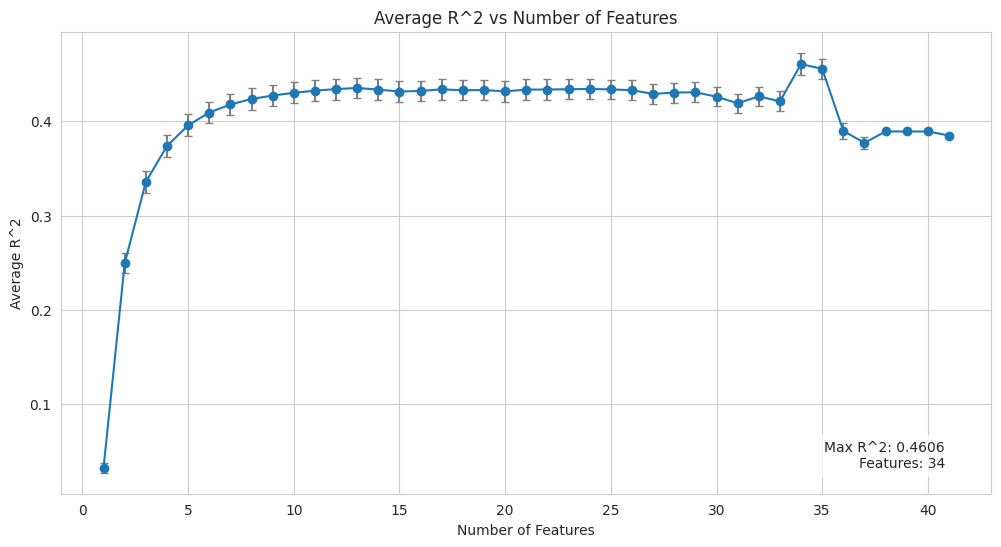

In [158]:
r2_df = pd.read_csv('x02_ml_pipeline/output/both/r2_Stepwise.csv', index_col=0)
make_r2_by_feature_count_plot(r2_df)

#### Urban Data

##### Ridge Regression

In [159]:
df = pd.read_csv('x02_ml_pipeline/output/urban_only/metrics_Ridge.csv', index_col=0)
summarize_bootstrap_results(df)

,Variable,Mean,Std Dev
0,r2,0.003143,0.374048
1,spearman,0.679510,0.012727
2,pearson,0.694427,0.055498
3,recall_10,0.428391,0.032440
4,recall_20,0.535144,0.026103
5,recall_30,0.613318,0.016350
6,recall_40,0.687144,0.012591
7,recall_50,0.747969,0.009287
8,recall_60,0.808016,0.006659
9,recall_70,0.856409,0.005667


In [160]:
    fi = pd.read_csv('x02_ml_pipeline/output/urban_only/importances_Ridge.csv', index_col=0)
    fi

,0
ag_asset_AXE,-1.186721e-03
ag_asset_BARN,-2.894139e-04
ag_asset_CHICKEN HOUSE,-4.315542e-04
ag_asset_FORK,-9.487289e-05
ag_asset_GENERATOR,-4.434096e-05
ag_asset_GRAIN MILL,-1.226094e-04
ag_asset_GRANARY,-4.377789e-06
ag_asset_GRASS CUTTER,-8.493325e-03
ag_asset_HAMMER,-5.221713e-04
ag_asset_HAND HOE,-2.941555e-05


##### Random Forest


In [161]:
df = pd.read_csv('x02_ml_pipeline/output/urban_only/metrics_RandomForest.csv', index_col=0)
summarize_bootstrap_results(df)

,Variable,Mean,Std Dev
0,r2,0.109398,0.387895
1,spearman,0.699623,0.012057
2,pearson,0.688668,0.049004
3,recall_10,0.427367,0.038859
4,recall_20,0.553233,0.020896
5,recall_30,0.637169,0.013465
6,recall_40,0.698014,0.011106
7,recall_50,0.754439,0.009539
8,recall_60,0.808592,0.008201
9,recall_70,0.859095,0.005805


In [162]:
    fi = pd.read_csv('x02_ml_pipeline/output/urban_only/importances_RandomForest.csv', index_col=0)
    fi

,0
ag_asset_AXE,3.214034e-04
ag_asset_BARN,6.495250e-05
ag_asset_CHICKEN HOUSE,0.000000e+00
ag_asset_FORK,4.069138e-04
ag_asset_GENERATOR,6.707999e-06
ag_asset_GRAIN MILL,2.201826e-06
ag_asset_GRANARY,0.000000e+00
ag_asset_GRASS CUTTER,1.936671e-03
ag_asset_HAMMER,5.096132e-06
ag_asset_HAND HOE,0.000000e+00


##### Gradient Boosting

In [163]:
df = pd.read_csv('x02_ml_pipeline/output/urban_only/metrics_GradientBoosting.csv', index_col=0)
summarize_bootstrap_results(df)

,Variable,Mean,Std Dev
0,r2,-0.092711,0.561528
1,spearman,0.700373,0.016114
2,pearson,0.656996,0.074261
3,recall_10,0.452504,0.050583
4,recall_20,0.556000,0.025689
5,recall_30,0.635059,0.016819
6,recall_40,0.697482,0.011620
7,recall_50,0.755945,0.008706
8,recall_60,0.813533,0.007396
9,recall_70,0.861493,0.005971


In [164]:
    fi = pd.read_csv('x02_ml_pipeline/output/urban_only/importances_GradientBoosting.csv', index_col=0)
    fi

,0
ag_asset_AXE,3.377850e-04
ag_asset_BARN,1.635908e-04
ag_asset_CHICKEN HOUSE,1.704720e-05
ag_asset_FORK,2.929905e-04
ag_asset_GENERATOR,0.000000e+00
ag_asset_GRAIN MILL,0.000000e+00
ag_asset_GRANARY,0.000000e+00
ag_asset_GRASS CUTTER,2.026771e-04
ag_asset_HAMMER,7.114378e-06
ag_asset_HAND HOE,0.000000e+00


##### Stepwise OLS

In [165]:
df = pd.read_csv('x02_ml_pipeline/output/urban_only/metrics_Stepwise.csv', index_col=0)
df = summarize_bootstrap_results(df)
df


,Variable,Mean,Std Dev
0,r2,0.063022,0.398519
1,spearman,0.669852,0.131345
2,pearson,0.610206,0.100004
3,recall_10,0.358270,0.113609
4,recall_20,0.485200,0.112339
5,recall_30,0.590749,0.096053
6,recall_40,0.676645,0.086029
7,recall_50,0.748551,0.071910
8,recall_60,0.810232,0.062879
9,recall_70,0.863582,0.039897


In [166]:
fi = pd.read_csv('x02_ml_pipeline/output/urban_only/importances_Stepwise.csv', index_col=0)
fi


,Stepwise FI
intercept,4.057000e+00
durable_asset_Mortar/pestle (mtondo),6.077774e+06
hh_h03c,-4.600133e+06
hh_f09_SMOOTHED MUD,-5.690000e-01
durable_asset_Air conditioner,8.585417e+07
durable_asset_Washing machine,2.668423e+06
hh_h01_NO,3.430000e-01
hh_f19_YES,9.780000e-01
hh_t03_It was more than adequate for household needs,1.098000e+00
hh_head_education_5,1.249600e+01


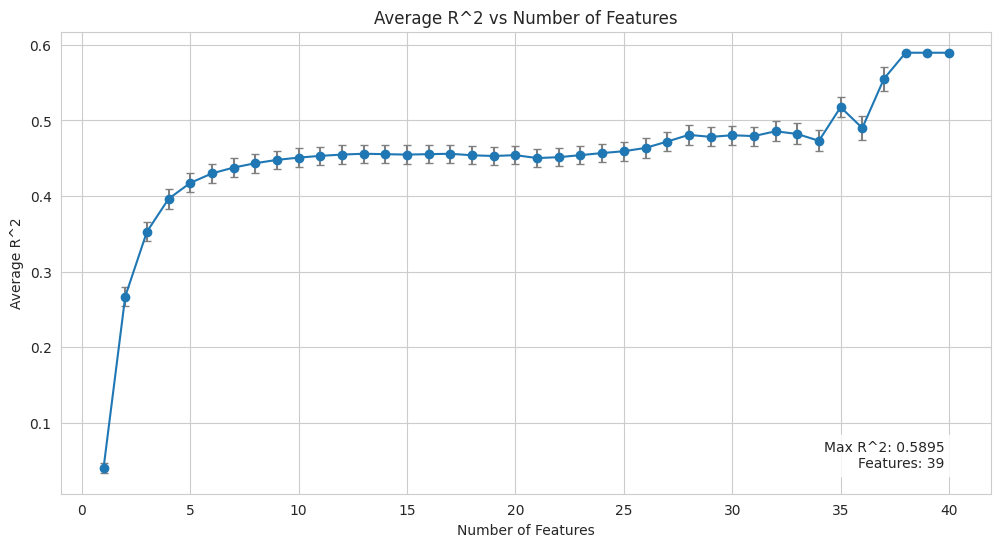

In [167]:
r2_df = pd.read_csv('x02_ml_pipeline/output/urban_only/r2_Stepwise.csv', index_col=0)
make_r2_by_feature_count_plot(r2_df)

#### Rural Data


##### Ridge Regression


In [168]:
df = pd.read_csv('x02_ml_pipeline/output/rural_only/metrics_Ridge.csv', index_col=0)
summarize_bootstrap_results(df)

,Variable,Mean,Std Dev
0,r2,0.007772,0.390192
1,spearman,0.677979,0.014157
2,pearson,0.690121,0.056255
3,recall_10,0.428804,0.033347
4,recall_20,0.534869,0.025667
5,recall_30,0.614700,0.017679
6,recall_40,0.684638,0.015712
7,recall_50,0.745109,0.008997
8,recall_60,0.806875,0.007319
9,recall_70,0.855780,0.006016


In [169]:
fi = pd.read_csv('x02_ml_pipeline/output/rural_only/importances_Ridge.csv', index_col=0)
fi

,0
ag_asset_AXE,-2.447200e-03
ag_asset_BARN,-5.973112e-04
ag_asset_CHICKEN HOUSE,-4.313637e-04
ag_asset_FORK,-3.174932e-04
ag_asset_GENERATOR,-9.324165e-05
ag_asset_GRAIN MILL,-3.800024e-04
ag_asset_GRANARY,-6.399251e-05
ag_asset_GRASS CUTTER,-4.398536e-02
ag_asset_HAMMER,-1.481565e-03
ag_asset_HAND HOE,-6.536779e-05


##### Random Forest

In [170]:
df = pd.read_csv('x02_ml_pipeline/output/rural_only/metrics_RandomForest.csv', index_col=0)
summarize_bootstrap_results(df)

,Variable,Mean,Std Dev
0,r2,0.124093,0.353802
1,spearman,0.698760,0.011853
2,pearson,0.689353,0.044860
3,recall_10,0.425686,0.037013
4,recall_20,0.551514,0.020319
5,recall_30,0.638875,0.015338
6,recall_40,0.698372,0.011809
7,recall_50,0.754132,0.009045
8,recall_60,0.807289,0.008487
9,recall_70,0.858598,0.006294


In [171]:
fi = pd.read_csv('x02_ml_pipeline/output/rural_only/importances_RandomForest.csv', index_col=0)
fi

,0
ag_asset_AXE,8.539984e-05
ag_asset_BARN,9.814701e-05
ag_asset_CHICKEN HOUSE,7.346683e-05
ag_asset_FORK,0.000000e+00
ag_asset_GENERATOR,3.946534e-06
ag_asset_GRAIN MILL,0.000000e+00
ag_asset_GRANARY,0.000000e+00
ag_asset_GRASS CUTTER,3.349197e-04
ag_asset_HAMMER,1.654533e-04
ag_asset_HAND HOE,0.000000e+00


##### Gradient Boosting

In [172]:
df = pd.read_csv('x02_ml_pipeline/output/rural_only/metrics_GradientBoosting.csv', index_col=0)
summarize_bootstrap_results(df)

,Variable,Mean,Std Dev
0,r2,-0.027553,0.516298
1,spearman,0.698061,0.018395
2,pearson,0.667613,0.065879
3,recall_10,0.452535,0.050191
4,recall_20,0.553744,0.027744
5,recall_30,0.637810,0.019046
6,recall_40,0.697148,0.014165
7,recall_50,0.754186,0.010605
8,recall_60,0.811071,0.008759
9,recall_70,0.860027,0.008042


In [173]:
fi = pd.read_csv('x02_ml_pipeline/output/rural_only/importances_GradientBoosting.csv', index_col=0)
fi

,0
ag_asset_AXE,1.720521e-04
ag_asset_BARN,0.000000e+00
ag_asset_CHICKEN HOUSE,6.196176e-04
ag_asset_FORK,0.000000e+00
ag_asset_GENERATOR,0.000000e+00
ag_asset_GRAIN MILL,0.000000e+00
ag_asset_GRANARY,0.000000e+00
ag_asset_GRASS CUTTER,0.000000e+00
ag_asset_HAMMER,0.000000e+00
ag_asset_HAND HOE,0.000000e+00


##### Stepwise OLS

In [174]:
df = pd.read_csv('x02_ml_pipeline/output/rural_only/metrics_Stepwise.csv', index_col=0)
summarize_bootstrap_results(df)


,Variable,Mean,Std Dev
0,r2,0.127327,0.272008
1,spearman,0.649163,0.110489
2,pearson,0.608049,0.100737
3,recall_10,0.334541,0.089952
4,recall_20,0.471052,0.093274
5,recall_30,0.573426,0.077373
6,recall_40,0.662718,0.067708
7,recall_50,0.736981,0.058018
8,recall_60,0.802931,0.045370
9,recall_70,0.858014,0.032595


In [175]:
fi = pd.read_csv('x02_ml_pipeline/output/rural_only/importances_Stepwise.csv', index_col=0)
fi


,Stepwise FI
intercept,3.816000e+00
"durable_asset_Cupboard, drawers, bureau",6.889471e+07
hh_h03c,-8.892278e+06
hh_f41_Flush to septic tank,4.455000e+00
durable_asset_Computer equipment & accessories,5.304815e+07
durable_asset_Washing machine,5.507775e+06
hh_h04_YES,-6.950000e-01
ag_asset_CHICKEN HOUSE,6.974948e+06
hh_head_education_10,5.670000e-01
hh_f36_PIPED TO NEIGHBOR,5.950000e-01


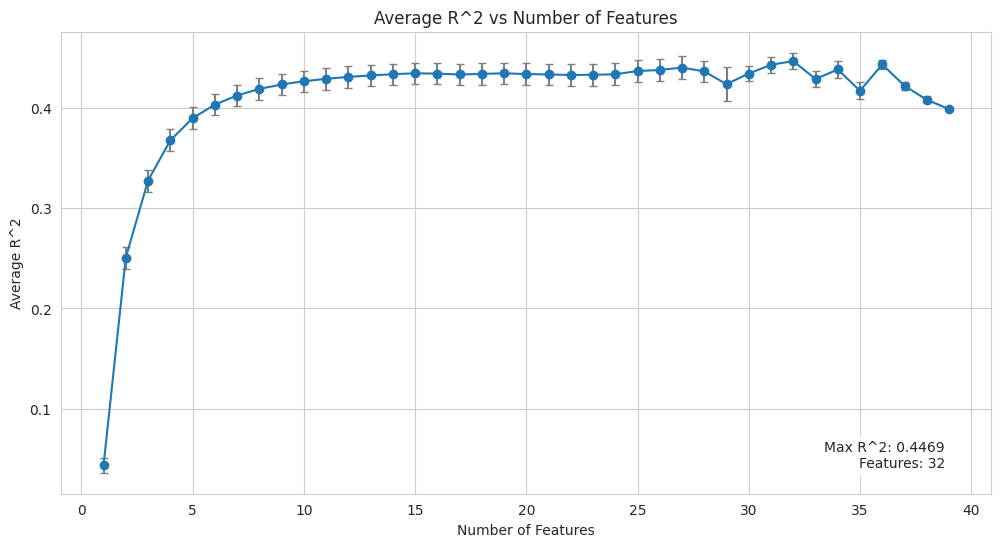

In [176]:
r2_df = pd.read_csv('x02_ml_pipeline/output/rural_only/r2_Stepwise.csv', index_col=0)
make_r2_by_feature_count_plot(r2_df)